In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn import svm
from sklearn.metrics import accuracy_score


In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 80359570.30it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103889960.40it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26819190.20it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17350208.35it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


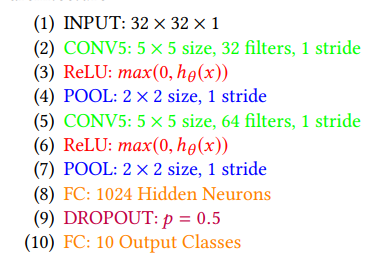

따라서 코드를 아래와 같이 작성했다.

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        self.fc = nn.Sequential(nn.Linear(18*18*64, 1024), 
                               nn.Dropout(p=0.5),
                               nn.Linear(1024, 10))
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

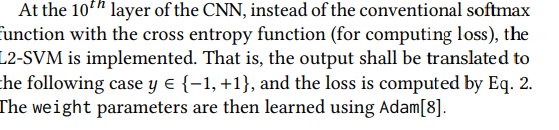

기존의 cross_entropy를 대체해서 l2_svm이 적용되어야 한다. 따라서 손실함수로 MultiMarginLoss를 적용했고, MultiMarginLoss의 p값(규제가 l1이면  p=1, 규제가 l2면 p=2로 설정)을 2로 설정.

그리고 옵티마이저로 adam을 사용해라고 해서 adam을 적용한 모습이다.

그리고 혹시나 l2규제가 틀렸을까봐 adam에도 l2규제를 적용해봤다.

In [17]:
import torch.optim as optim


epochs = 10
learning_rate = 0.001
weight_decay = 0.0001  # L2

model = CNN().to(device)


criterion = nn.MultiMarginLoss(p=2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 학습
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data


        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()


        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #l2규제
        l2_reg = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_reg += torch.norm(param, p=2)
        loss += weight_decay * l2_reg

        loss.backward()
        optimizer.step()


        running_loss += loss.item()


    print(f'Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}')

print('Finished Training')


/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [100, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:26.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 0.5111665945624312
Epoch 2, Loss: 0.03068653519032523
Epoch 3, Loss: 0.02450850049809863
Epoch 4, Loss: 0.023552935332991184
Epoch 5, Loss: 0.02255244699229176
Epoch 6, Loss: 0.0213761538763841
Epoch 7, Loss: 0.022496160565254587
Epoch 8, Loss: 0.0225732279708609
Epoch 9, Loss: 0.021046378110380223
Epoch 10, Loss: 0.019564102882286535
Finished Training
